In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [3]:
# Mein zweiter Anlauf, Regression nach zu machen. 
# Datensatz Auto MPG und das Ziel ist es den Brennstoff verbrauch zu bestimmen

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 5us/step


In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']

# Aus der CSV ein Pandas Dataset machen
dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# Auf lücken prüfen..
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# PS hat 6 fehlende Daten. Diese könnten basierend auf ähnlichkeit geschätzt / berechnet werden. Was aber sehr genau gemacht werden muss, sonst ggf das Modell schwächt. Daher -> hier einfach raus damit
dataset = dataset.dropna()

# One-Hot für Origin
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


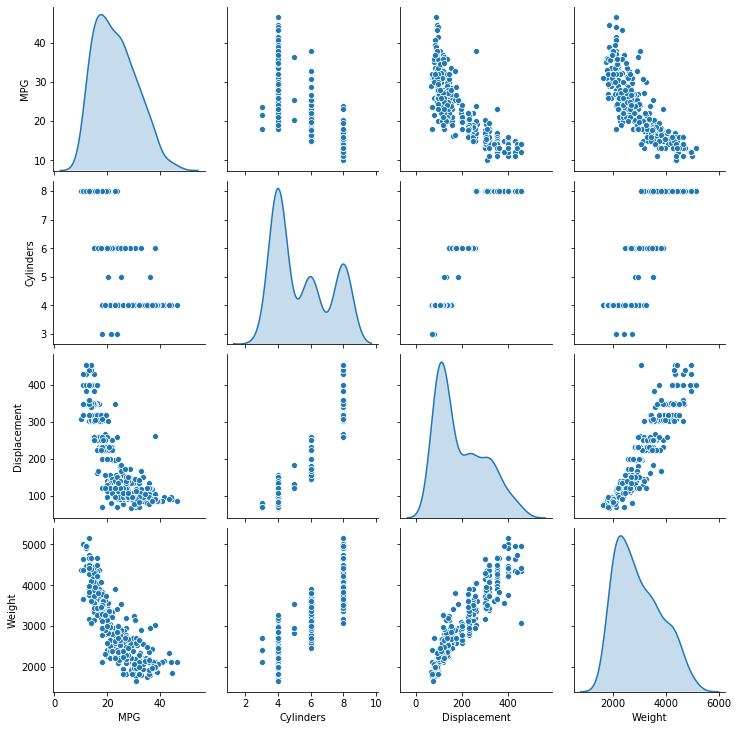

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [10]:
# Wir wollen MPG bestimmen, also muss das vorher von den Daten entfernt werden..
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [11]:
# Viele Werte, viele verschiedene Einheiten. -> Normalizieren
def norm(x):
    return (x - train_stats["mean"]) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset) # -> Auch Test Daten nur basierend auf Train Daten normalizieren!!!

In [13]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse']) # MAE = Mean Absolute Error
    return model

model = build_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Ich kann die Daten in das Model reichen. Auch wenn bullshit als Ergebnis kommt, da noch nicht trainiert
example_batch = normed_train_data[:10]
example_res = model.predict(example_batch)
example_res

array([[-0.26050752],
       [-0.4059603 ],
       [-0.5267592 ],
       [-0.39396942],
       [-0.06908894],
       [-0.30877417],
       [-0.09306572],
       [-0.5323585 ],
       [-0.16736525],
       [-0.02808854]], dtype=float32)

In [19]:
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:581.5510,  mae:22.8727,  mse:581.5510,  val_loss:575.6194,  val_mae:22.7273,  val_mse:575.6194,  
....................................................................................................
Epoch: 100, loss:6.0240,  mae:1.7069,  mse:6.0240,  val_loss:9.2000,  val_mae:2.2786,  val_mse:9.2000,  
....................................................................................................
Epoch: 200, loss:5.5411,  mae:1.6096,  mse:5.5411,  val_loss:8.7508,  val_mae:2.2542,  val_mse:8.7508,  
....................................................................................................
Epoch: 300, loss:4.5240,  mae:1.4449,  mse:4.5240,  val_loss:8.7793,  val_mae:2.2711,  val_mse:8.7793,  
....................................................................................................
Epoch: 400, loss:4.1093,  mae:1.3593,  mse:4.1093,  val_loss:9.0370,  val_mae:2.3287,  val_mse:9.0370,  
..............................................................

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.294922,0.965070,2.294922,8.908047,2.196049,8.908047,995
996,2.314153,0.924285,2.314153,8.956911,2.225830,8.956911,996
997,2.252439,0.950992,2.252439,9.015251,2.285049,9.015251,997
998,2.182408,0.908675,2.182408,10.077270,2.396273,10.077270,998
999,2.381496,0.965517,2.381496,9.299071,2.317209,9.299071,999


Text(0, 0.5, 'MAE [MPG]')

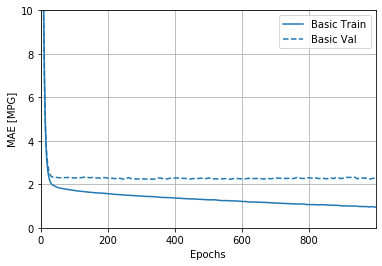

In [22]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

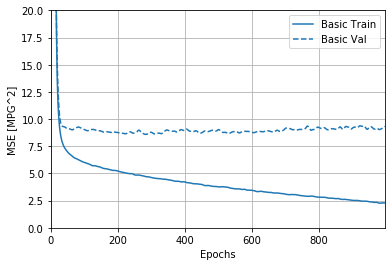

In [23]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [24]:
# Wie zu erkennen, wird unser Modell nicht wirklich besser. Daher EarlyStopping einbauen, um ein zu gewaltiges Overfitting zu verhindern

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 10 Epochen anschauen nach verbesserung
early_history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:550.0025,  mae:22.1120,  mse:550.0025,  val_loss:535.6192,  val_mae:21.7153,  val_mse:535.6192,  
......................................................................

Text(0, 0.5, 'MAE [MPG]')

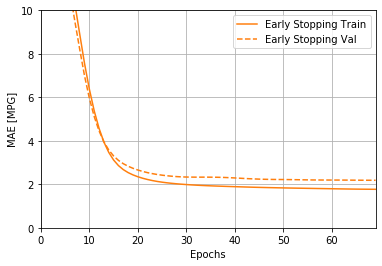

In [25]:
# Wie zu sehen, hat das Training keine 100 Epochen durchgehalten
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [26]:
# Wir sehen einen avg error von +/- 2 MPG. Also 2 Meilen pro Gallone. 
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Test Datenset mit Mean Abs Error (MSE): {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.8075 - mae: 1.8524 - mse: 5.8075
Test Datenset mit Mean Abs Error (MSE):  1.85 MPG


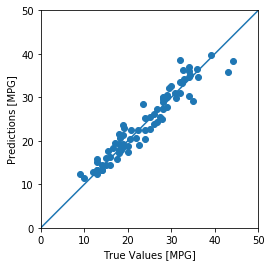

In [27]:
# Vorhersagen treffen und Visualisieren:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

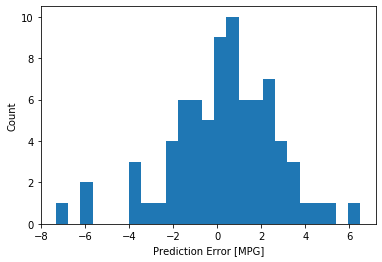

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:
# Keine Gaußverteilung. -> Ggf weil Anzahl der Daten recht gering ist